## $\fbox{3-4}$ 健診結果別入院発生率状況の観察

### 準備 & 作成したデータの読み込み

In [1]:
# グラフを移動拡大縮小したい場合
%matplotlib notebook
# グラフをインラインで表示
# %matplotlib inline

import gc
import math
import pickle

# 本書 1-3 章の関数群を含む自作ライブラリ
import mylibs.mylib1 as mylib1
import mylibs.mylib2 as mylib2
import mylibs.mylib3 as mylib3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

# 表示する行・列の数を設定
pd.options.display.max_rows = 8
pd.options.display.max_columns = 12

# matplotlib のフォントを設定
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

## データの読み込みと加工

### 健診結果データの読み込み

In [2]:
df_hc = pd.read_csv('./pseudo_medical/records/incl_bp/healthckeckup.csv')

print(df_hc.shape)
df_hc.head()

(12632, 4)


,iid,hc_ym,dbp,sbp
0,i000000,2010/07,88,131
1,i000000,2011/07,81,138
2,i000000,2012/07,88,140
3,i000000,2013/07,70,127
4,i000002,2010/07,76,114


### df_info, df_commons を健診レコードを持つ者のみに絞り込む

In [3]:
df_info = pd.read_csv('./pseudo_medical/records/incl_bp/info.csv')
df_commons = pd.read_csv('./pseudo_medical/records/incl_bp/commons.csv')

print(len(df_hc.iid.unique()), len(
    df_info.iid.unique()), len(df_commons.iid.unique()))

2241 4815 4742


In [4]:
df_info = df_info[df_info['iid'].isin(df_hc['iid'])]
df_commons = df_commons[df_commons['iid'].isin(df_hc['iid'])]

print(len(df_hc.iid.unique()), len(
    df_info.iid.unique()), len(df_commons.iid.unique()))

2241 2241 2234


## ALB テーブル・エクスポージャテーブルを作成

In [5]:
# 分析開始時点 (2010年1月)
start_study_t = 2010
# 分析終了時点 (2019年12月)
end_study_t = 2019.999

npa_obs_ym = mylib1.create_npa_obs_ym(start_study_t, end_study_t)
df_info = mylib1.convert_ym_to_t_in_info(df_info)
df_alb_table = mylib1.create_alb_table_from_info(npa_obs_ym, df_info)
df_exposure_table = mylib1.create_exposure_table_from_alb_table(
    npa_obs_ym, df_alb_table)

In [6]:
print(df_alb_table.shape)
df_alb_table.head()

(2241, 131)


,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,...,2019/07,2019/08,2019/09,2019/10,2019/11,2019/12
0,i000000,M,1,1952/06,2010/01,2013/09,...,67,67,67,67,67,67
2,i000002,M,1,1978/03,2010/01,2016/09,...,41,41,41,41,41,41
5,i000007,F,1,1975/01,2010/01,2019/02,...,44,44,44,44,44,44
8,i000012,M,1,2010/01,2010/01,2019/12,...,9,9,9,9,9,9
9,i000013,M,2,1985/01,2010/01,2012/11,...,34,34,34,34,34,34


In [7]:
print(df_exposure_table.shape)
df_exposure_table.head()

(2241, 131)


,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,...,2019/07,2019/08,2019/09,2019/10,2019/11,2019/12
0,i000000,M,1,1952/06,2010/01,2013/09,...,0,0,0,0,0,0
2,i000002,M,1,1978/03,2010/01,2016/09,...,0,0,0,0,0,0
5,i000007,F,1,1975/01,2010/01,2019/02,...,0,0,0,0,0,0
8,i000012,M,1,2010/01,2010/01,2019/12,...,1,1,1,1,1,1
9,i000013,M,2,1985/01,2010/01,2012/11,...,0,0,0,0,0,0


## イベントテーブルの作成

In [8]:
df_event_table = df_alb_table.copy()
df_event_table[npa_obs_ym] = 0

In [9]:
# 入院レコードのみに限定
df_hosps = df_commons[df_commons['receipt_type'] == 'inpatient']

print(df_hosps.shape)
df_hosps.head()

(1138, 6)


,iid,rid,ym,receipt_type,admission_ym,days
220,i000007,r00000221,2016/06,inpatient,2016/06,15
221,i000007,r00000222,2016/07,inpatient,2016/06,2
357,i000018,r00000358,2011/01,inpatient,2011/01,4
412,i000023,r00000413,2010/08,inpatient,2010/08,9
1014,i000041,r00001015,2013/12,inpatient,2013/12,9


In [10]:
dfg = df_hosps.groupby(['iid', 'admission_ym'])
df_admissions = dfg['days'].sum().reset_index()

print(df_admissions.shape)
df_admissions.head()

(751, 3)


,iid,admission_ym,days
0,i000007,2016/06,17
1,i000018,2011/01,4
2,i000023,2010/08,9
3,i000041,2013/12,9
4,i000042,2010/03,7


In [11]:
for ym in npa_obs_ym:
    is_ym = (df_admissions['admission_ym'] == ym)
    iid_in_ym = df_admissions.loc[is_ym, 'iid'].values
    in_iid_in_ym = df_event_table['iid'].isin(iid_in_ym)
    df_event_table.loc[in_iid_in_ym, ym] = 1

df_event_table.head()

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,...,2019/07,2019/08,2019/09,2019/10,2019/11,2019/12
0,i000000,M,1,1952/06,2010/01,2013/09,...,0,0,0,0,0,0
2,i000002,M,1,1978/03,2010/01,2016/09,...,0,0,0,0,0,0
5,i000007,F,1,1975/01,2010/01,2019/02,...,0,0,0,0,0,0
8,i000012,M,1,2010/01,2010/01,2019/12,...,0,0,0,0,0,0
9,i000013,M,2,1985/01,2010/01,2012/11,...,0,0,0,0,0,0


In [12]:
df_event_table[npa_obs_ym].sum().sum()

751

## DBP テーブルの作成

In [13]:
df_dbp_table = df_alb_table.copy()
df_dbp_table[npa_obs_ym] = 0

df_dbp_table.head()

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,...,2019/07,2019/08,2019/09,2019/10,2019/11,2019/12
0,i000000,M,1,1952/06,2010/01,2013/09,...,0,0,0,0,0,0
2,i000002,M,1,1978/03,2010/01,2016/09,...,0,0,0,0,0,0
5,i000007,F,1,1975/01,2010/01,2019/02,...,0,0,0,0,0,0
8,i000012,M,1,2010/01,2010/01,2019/12,...,0,0,0,0,0,0
9,i000013,M,2,1985/01,2010/01,2012/11,...,0,0,0,0,0,0


In [14]:
df_hc.index = df_hc.iid
idx = df_dbp_table.index
df_dbp_table.index = df_dbp_table.iid

In [15]:
ym = npa_obs_ym[10]
ss_dbp = df_hc.loc[(df_hc.hc_ym == ym), 'dbp']

print(ss_dbp)

iid
i001221    87
i002547    80
i002595    71
i003361    91
i005382    64
i006946    75
i007415    67
Name: dbp, dtype: int64


In [16]:
print(len(df_dbp_table[ym]), len(ss_dbp))

2241 7


In [17]:
df_dbp_table[ym] = ss_dbp

print(df_dbp_table[ym])

iid
i000000   NaN
i000002   NaN
i000007   NaN
i000012   NaN
           ..
i008243   NaN
i008246   NaN
i008249   NaN
i008263   NaN
Name: 2010/11, Length: 2241, dtype: float64


In [18]:
df_dbp_table.loc[ss_dbp.index, ym]

iid
i001221    87.0
i002547    80.0
i002595    71.0
i003361    91.0
i005382    64.0
i006946    75.0
i007415    67.0
Name: 2010/11, dtype: float64

In [19]:
for ym in npa_obs_ym:
    ss_dbp = df_hc.loc[(df_hc.hc_ym == ym), 'dbp']
    df_dbp_table[ym] = ss_dbp

df_dbp_table.head()

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,...,2019/07,2019/08,2019/09,2019/10,2019/11,2019/12
iid,,,,,,,,,,,,,
i000000,i000000,M,1,1952/06,2010/01,2013/09,...,NaN,NaN,NaN,NaN,NaN,NaN
i000002,i000002,M,1,1978/03,2010/01,2016/09,...,NaN,NaN,NaN,NaN,NaN,NaN
i000007,i000007,F,1,1975/01,2010/01,2019/02,...,NaN,NaN,NaN,NaN,NaN,NaN
i000012,i000012,M,1,2010/01,2010/01,2019/12,...,77.0,NaN,NaN,NaN,NaN,NaN
i000013,i000013,M,2,1985/01,2010/01,2012/11,...,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_dbp_table[npa_obs_ym] = df_dbp_table[npa_obs_ym].fillna(
    method='ffill', axis=1)

df_dbp_table.head()

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,...,2019/07,2019/08,2019/09,2019/10,2019/11,2019/12
iid,,,,,,,,,,,,,
i000000,i000000,M,1,1952/06,2010/01,2013/09,...,70.0,70.0,70.0,70.0,70.0,70.0
i000002,i000002,M,1,1978/03,2010/01,2016/09,...,70.0,70.0,70.0,70.0,70.0,70.0
i000007,i000007,F,1,1975/01,2010/01,2019/02,...,76.0,76.0,76.0,76.0,76.0,76.0
i000012,i000012,M,1,2010/01,2010/01,2019/12,...,77.0,77.0,77.0,77.0,77.0,77.0
i000013,i000013,M,2,1985/01,2010/01,2012/11,...,73.0,73.0,73.0,73.0,73.0,73.0


In [21]:
df_dbp_table.index = idx

df_dbp_table.head()

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,...,2019/07,2019/08,2019/09,2019/10,2019/11,2019/12
0,i000000,M,1,1952/06,2010/01,2013/09,...,70.0,70.0,70.0,70.0,70.0,70.0
2,i000002,M,1,1978/03,2010/01,2016/09,...,70.0,70.0,70.0,70.0,70.0,70.0
5,i000007,F,1,1975/01,2010/01,2019/02,...,76.0,76.0,76.0,76.0,76.0,76.0
8,i000012,M,1,2010/01,2010/01,2019/12,...,77.0,77.0,77.0,77.0,77.0,77.0
9,i000013,M,2,1985/01,2010/01,2012/11,...,73.0,73.0,73.0,73.0,73.0,73.0


## SBP テーブルの作成

In [22]:
df_sbp_table = df_dbp_table.copy()
df_sbp_table[npa_obs_ym] = 0

idx = df_sbp_table.index
df_sbp_table.index = df_sbp_table.iid

for ym in npa_obs_ym:
    ss_sbp = df_hc.loc[(df_hc.hc_ym == ym), 'sbp']
    df_sbp_table[ym] = ss_sbp

df_sbp_table[npa_obs_ym] = df_sbp_table[npa_obs_ym].fillna(
    method='ffill', axis=1)

df_sbp_table.index = idx

df_sbp_table.head()

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,...,2019/07,2019/08,2019/09,2019/10,2019/11,2019/12
0,i000000,M,1,1952/06,2010/01,2013/09,...,127.0,127.0,127.0,127.0,127.0,127.0
2,i000002,M,1,1978/03,2010/01,2016/09,...,115.0,115.0,115.0,115.0,115.0,115.0
5,i000007,F,1,1975/01,2010/01,2019/02,...,128.0,128.0,128.0,128.0,128.0,128.0
8,i000012,M,1,2010/01,2010/01,2019/12,...,113.0,113.0,113.0,113.0,113.0,113.0
9,i000013,M,2,1985/01,2010/01,2012/11,...,118.0,118.0,118.0,118.0,118.0,118.0


## 発生率の可視化

In [23]:
df_alb_table[npa_obs_ym] = df_alb_table[npa_obs_ym] // 20 * 20
df_dbp_table[npa_obs_ym] = df_dbp_table[npa_obs_ym] // 20 * 20
df_sbp_table[npa_obs_ym] = df_sbp_table[npa_obs_ym] // 20 * 20

print(df_alb_table[npa_obs_ym].min().min(),
      df_alb_table[npa_obs_ym].max().max())
print(df_dbp_table[npa_obs_ym].min().min(),
      df_dbp_table[npa_obs_ym].max().max())
print(df_sbp_table[npa_obs_ym].min().min(),
      df_sbp_table[npa_obs_ym].max().max())

-20 60
40.0 140.0
60.0 180.0


In [24]:
df_summary = pd.DataFrame()

for sex in ['M', 'F']:
    df_alb_sex = df_alb_table[df_alb_table.sex == sex]
    df_exposure_sex = df_exposure_table[df_exposure_table.sex == sex]
    df_event_sex = df_event_table[df_event_table.sex == sex]
    df_dbp_sex = df_dbp_table[df_dbp_table.sex == sex]
    df_sbp_sex = df_sbp_table[df_sbp_table.sex == sex]
    for alb in np.arange(0, 80, 20):
        for dbp in np.arange(40, 160, 20):
            for sbp in np.arange(60, 200, 20):
                is_alb = (df_alb_sex[npa_obs_ym] == alb)
                is_dbp = (df_dbp_sex[npa_obs_ym] == dbp)
                is_sbp = (df_sbp_sex[npa_obs_ym] == sbp)
                exposure = df_exposure_sex[is_alb &
                                           is_dbp & is_sbp].fillna(0).sum().sum()
                event = df_event_sex[is_alb & is_dbp &
                                     is_sbp].fillna(0).sum().sum()
                df = pd.DataFrame([[sex, alb, dbp, sbp, exposure, event]],
                                  columns=['sex', 'alb', 'dbp', 'sbp', 'exposure', 'event'])
                df_summary = pd.concat([df_summary, df], axis=0)

df_summary

,sex,alb,dbp,sbp,exposure,event
0,M,0,40,60,0.0,0.0
0,M,0,40,80,547.0,1.0
0,M,0,40,100,0.0,0.0
0,M,0,40,120,0.0,0.0
...,...,...,...,...,...,...
0,F,60,140,120,0.0,0.0
0,F,60,140,140,0.0,0.0
0,F,60,140,160,0.0,0.0
0,F,60,140,180,0.0,0.0


In [25]:
df_summary['rate'] = df_summary.event / df_summary.exposure

df_summary

,sex,alb,dbp,sbp,exposure,event,rate
0,M,0,40,60,0.0,0.0,NaN
0,M,0,40,80,547.0,1.0,0.001828
0,M,0,40,100,0.0,0.0,NaN
0,M,0,40,120,0.0,0.0,NaN
...,...,...,...,...,...,...,...
0,F,60,140,120,0.0,0.0,NaN
0,F,60,140,140,0.0,0.0,NaN
0,F,60,140,160,0.0,0.0,NaN
0,F,60,140,180,0.0,0.0,NaN


In [26]:
df_summary.rate.max()

0.05263157894736842

In [27]:
dict_summary = {'M': {}, 'F': {}}
for sex in ['M', 'F']:
    for alb in np.arange(0, 80, 20):
        df = df_summary[(df_summary.sex == sex) & (df_summary.alb == alb)]
        xticks = df.dbp.unique()
        yticks = df.sbp.unique()
        r = len(xticks)
        c = len(yticks)
        dict_summary[sex][alb] = df.rate.values.reshape(r, c)

<IPython.core.display.Javascript object>


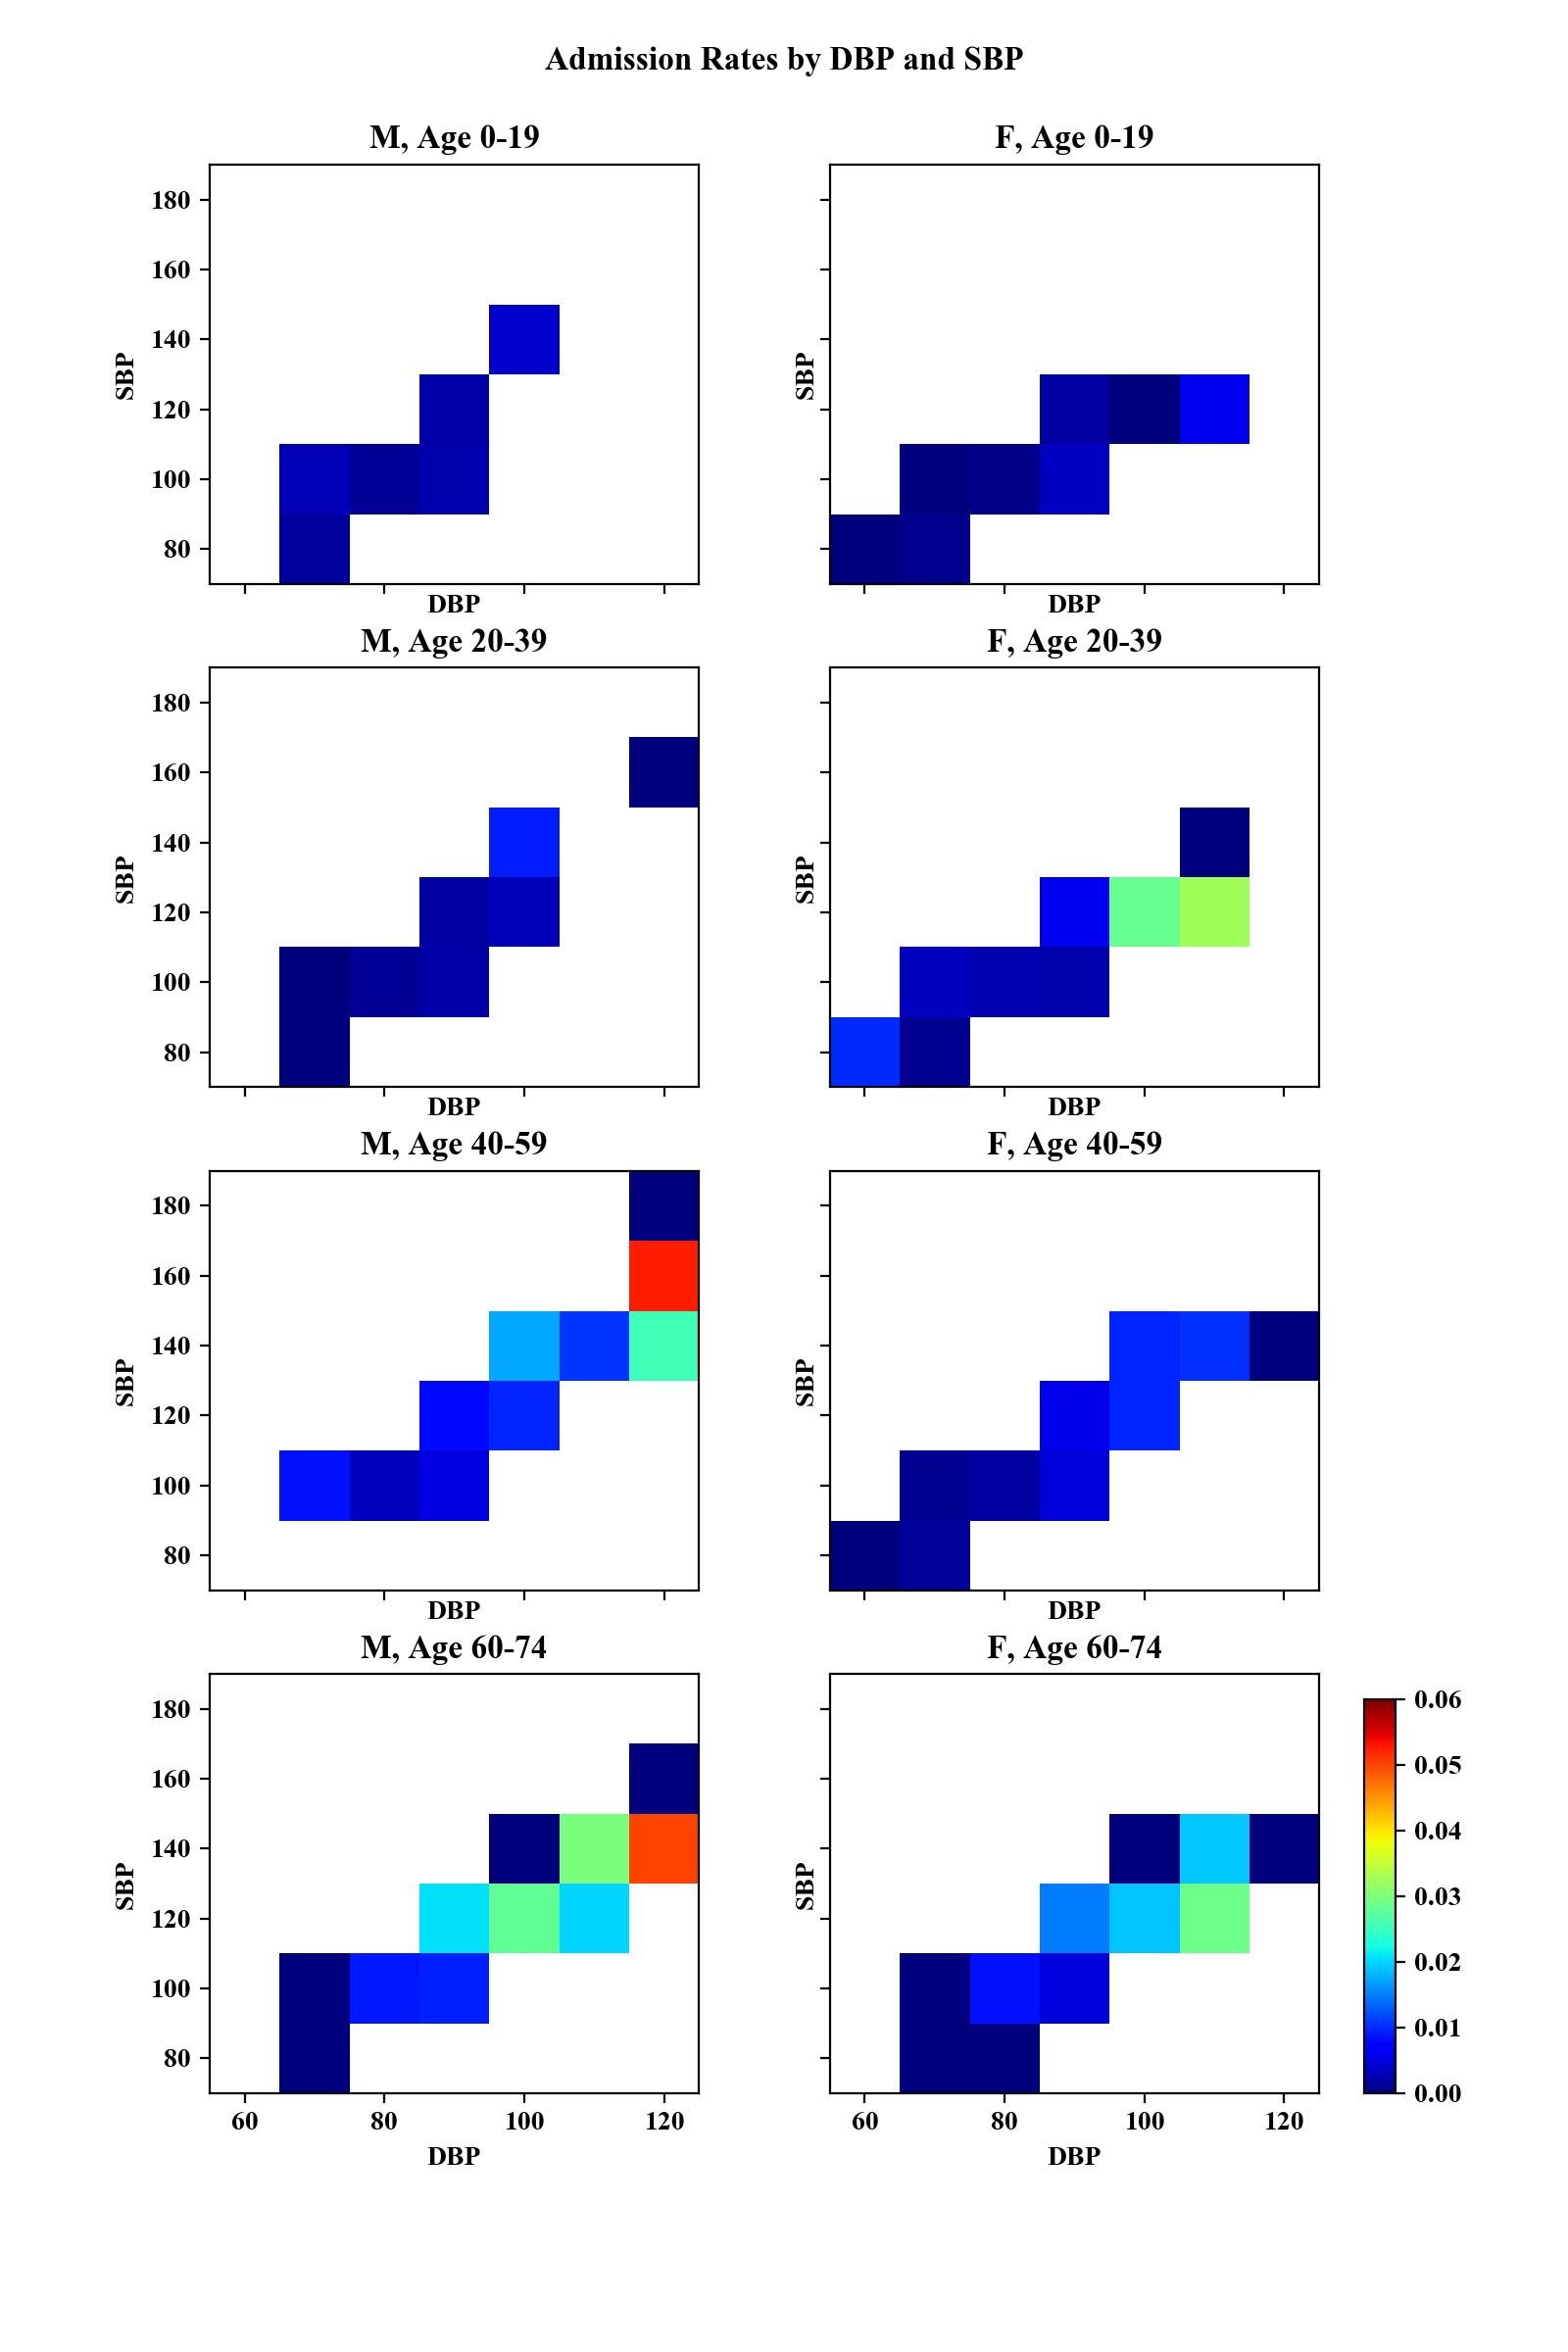

In [28]:
sexes = ['M', 'F']
ages = {0: 'Age 0-19', 20: 'Age 20-39', 40: 'Age 40-59', 60: 'Age 60-74'}

fig, axes = plt.subplots(4, 2, figsize=(8, 12), sharex=True, sharey=True)
fig.suptitle('Admission Rates by DBP and SBP')
for i in [0, 1]:
    sex = sexes[i]
    for j in np.arange(4):
        alb = j * 20
        im = axes[j, i].imshow(dict_summary[sex][alb],
                               vmin=0, vmax=0.06, cmap='jet')
        axes[j, i].set_xticklabels(xticks)
        axes[j, i].set_yticklabels(yticks)
        axes[j, i].invert_yaxis()
        axes[j, i].set_title(sex + ', ' + ages[alb])
        axes[j, i].set_xlabel('DBP')
        axes[j, i].set_ylabel('SBP')

# fig.colorbar(im)
axpos = axes[j, i].get_position()
cbar_ax = fig.add_axes([0.87, axpos.y0, 0.02, axpos.height])
cbar = fig.colorbar(im, cax=cbar_ax)
fig.subplots_adjust(right=0.85, top=0.93)

## まとめ